# Ross Sea synthetic gravity inversion

Here we try to recover the true bathymetry of the Ross Sea from a synthetic airborne gravity survey. See notebook `Ross_Sea_synthetic_model.ipynb` for the creation of this synthetic gravity data and the low-resolution starting model of bathymetry. 

import packages

In [2]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle
import verde as vd
import xarray as xr
import pandas as pd
import numpy as np
from polartoolkit import maps, fetch, regions
from polartoolkit import utils as polar_utils
import string
import os
import RIS_gravity_inversion.synthetic as RIS_synth
import RIS_gravity_inversion.plotting as RIS_plotting
import pygmt
from tqdm.autonotebook import tqdm
import copy

os.environ['POLARTOOLKIT_HEMISPHERE']='south'

logging.getLogger().setLevel(logging.INFO)

from invert4geom import inversion, plotting, synthetic, uncertainty, utils, regional, cross_validation, optimization

# Get synthetic model data

INFO:root:using preprocessed 5km grid since spacing is > 5km
INFO:root:returning grid with new region and/or registration, same spacing


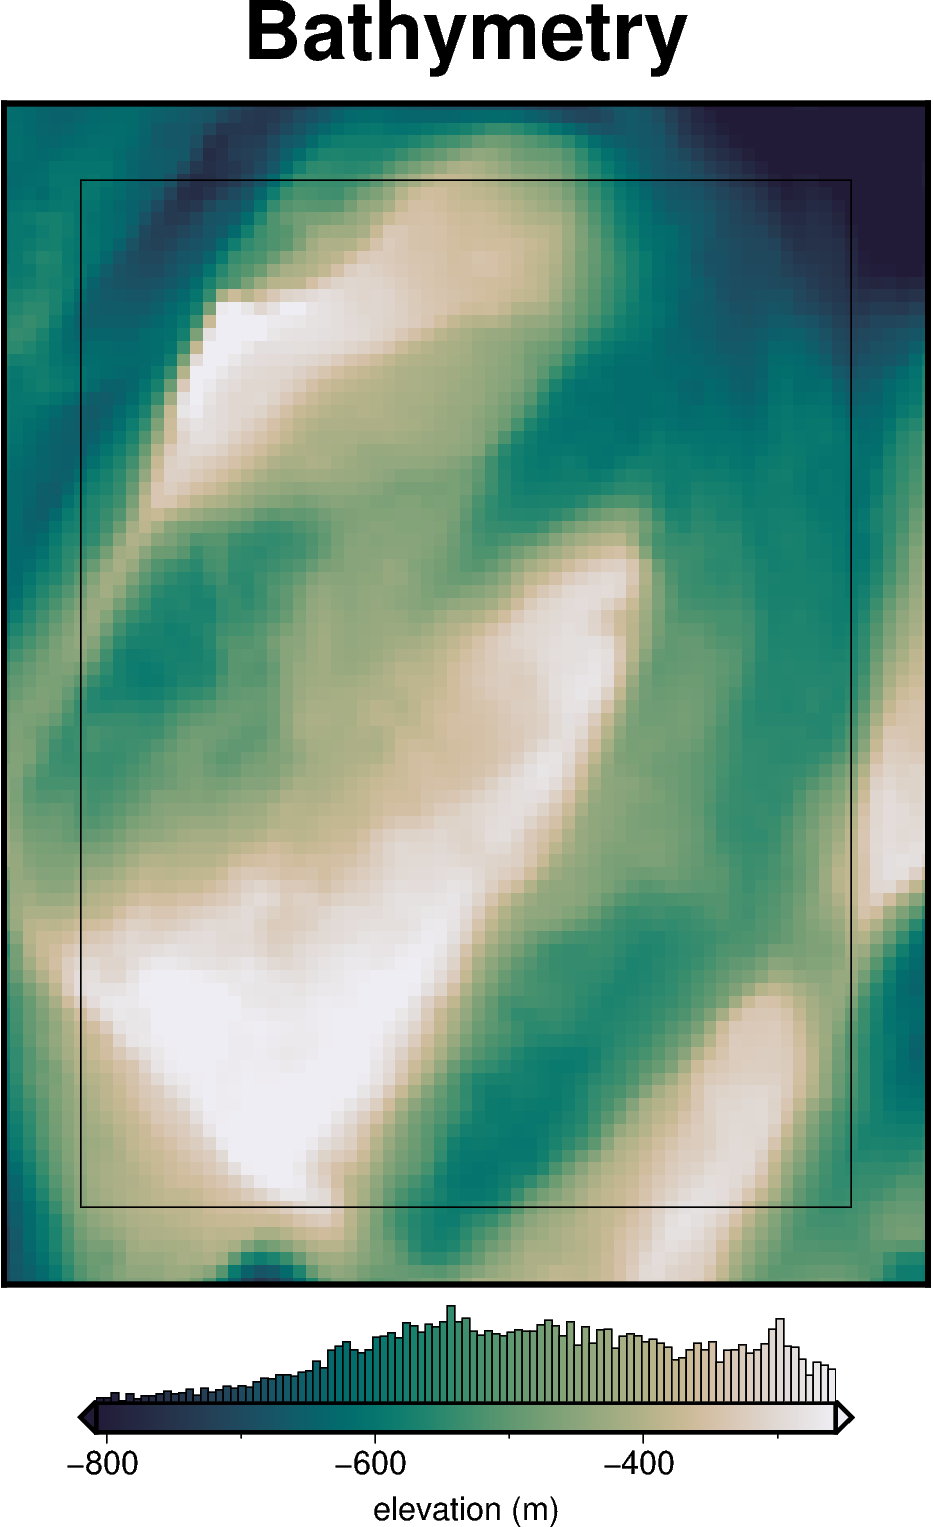

  0%|          | 0/4941 [00:00<?, ?it/s]

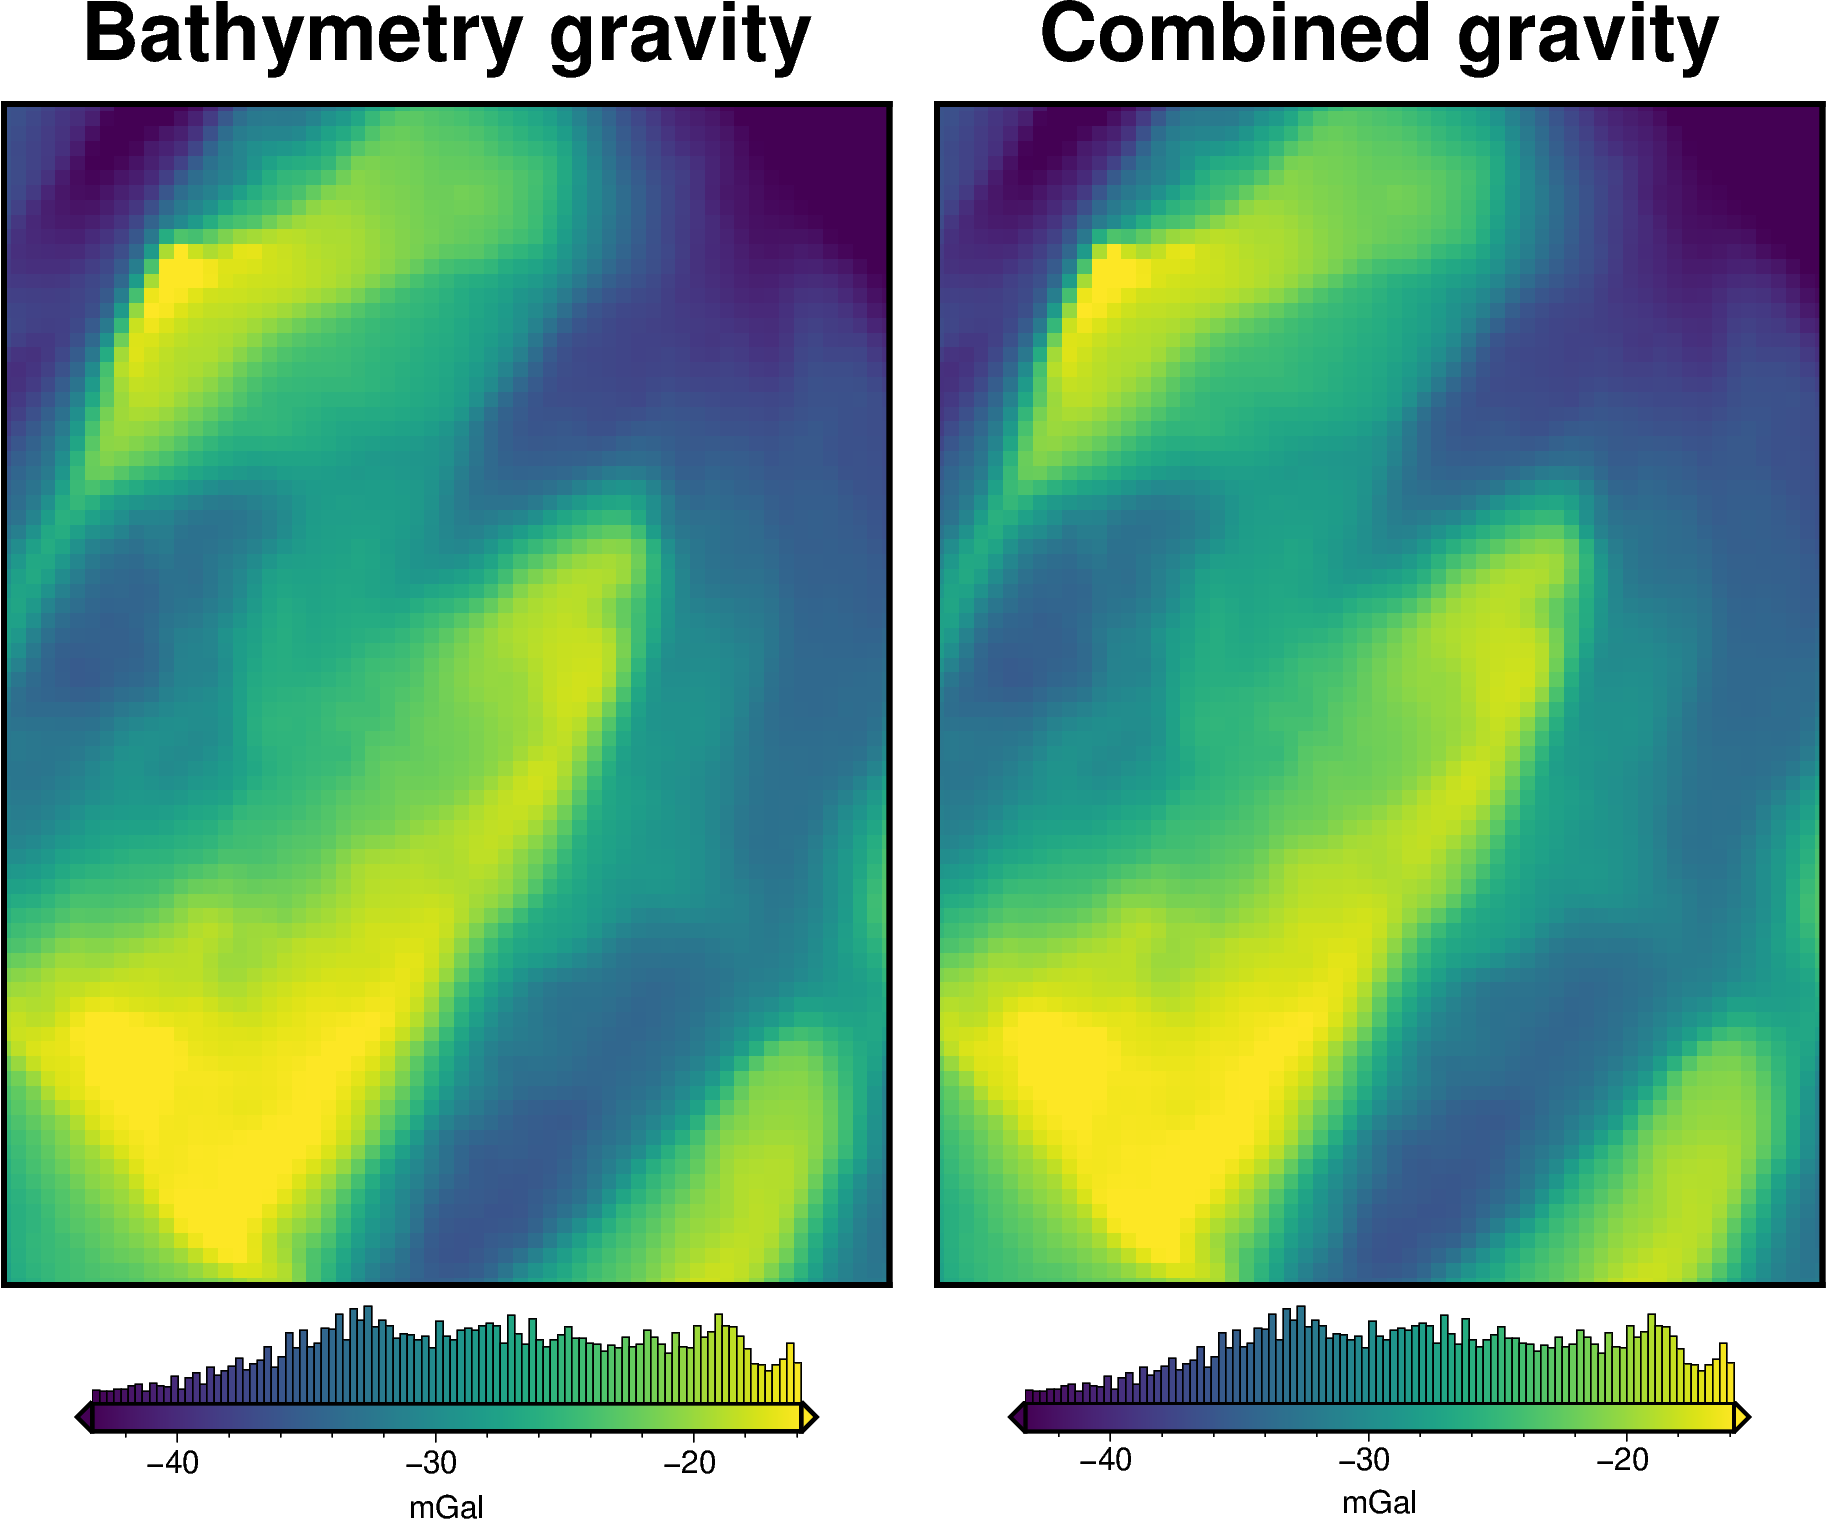

In [ ]:
# set grid parameters
spacing = 5e3
inversion_region = (-40e3, 260e3, -1800e3, -1400e3)

bathymetry, basement, grav_df = RIS_synth.load_synthetic_model(
    spacing=spacing,
    buffer=spacing*6,
    gravity_noise=0,
)
buffer_region = polar_utils.get_grid_info(bathymetry)[1]

# rename the full res gravity column
grav_df=grav_df.rename(columns={"gravity_anomaly": "gravity_anomaly_full_res"})

In [4]:
grav_df.describe()

,northing,easting,upward,bathymetry_grav,basement_grav,disturbance,uncert,gravity_anomaly_full_res
count,4.941000e+03,4941.00000,4941.0,4941.000000,4941.0,4941.000000,4941.0,4941.000000
mean,-1.600000e+06,110000.00000,1000.0,-28.076339,0.0,-28.076339,0.0,-28.076339
std,1.169164e+05,88042.99419,0.0,7.267542,0.0,7.267542,0.0,7.267542
min,-1.800000e+06,-40000.00000,1000.0,-50.834525,0.0,-50.834525,0.0,-50.834525
25%,-1.700000e+06,35000.00000,1000.0,-33.380910,0.0,-33.380910,0.0,-33.380910
50%,-1.600000e+06,110000.00000,1000.0,-28.037682,0.0,-28.037682,0.0,-28.037682
75%,-1.500000e+06,185000.00000,1000.0,-21.983838,0.0,-21.983838,0.0,-21.983838
max,-1.400000e+06,260000.00000,1000.0,-13.088736,0.0,-13.088736,0.0,-13.088736


# Make starting bathymetry model

In [5]:
# make a flat starting model at the mean elevation of the true bathymetry
starting_bathymetry = utils.create_topography(
    method="flat",
    upwards=bathymetry.values.mean(),
    region=buffer_region,
    spacing=spacing,
)
starting_bathymetry

<xarray.DataArray 'upward' (northing: 93, easting: 73)> Size: 54kB
array([[-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       ...,
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631]])
Coordinates:
  * easting   (easting) float64 584B -7e+04 -6.5e+04 -6e+04 ... 2.85e+05 2.9e+05
  * northing  (northing) float64 744B -1.83e+06 -1.825e+06 ... -1.37e+06

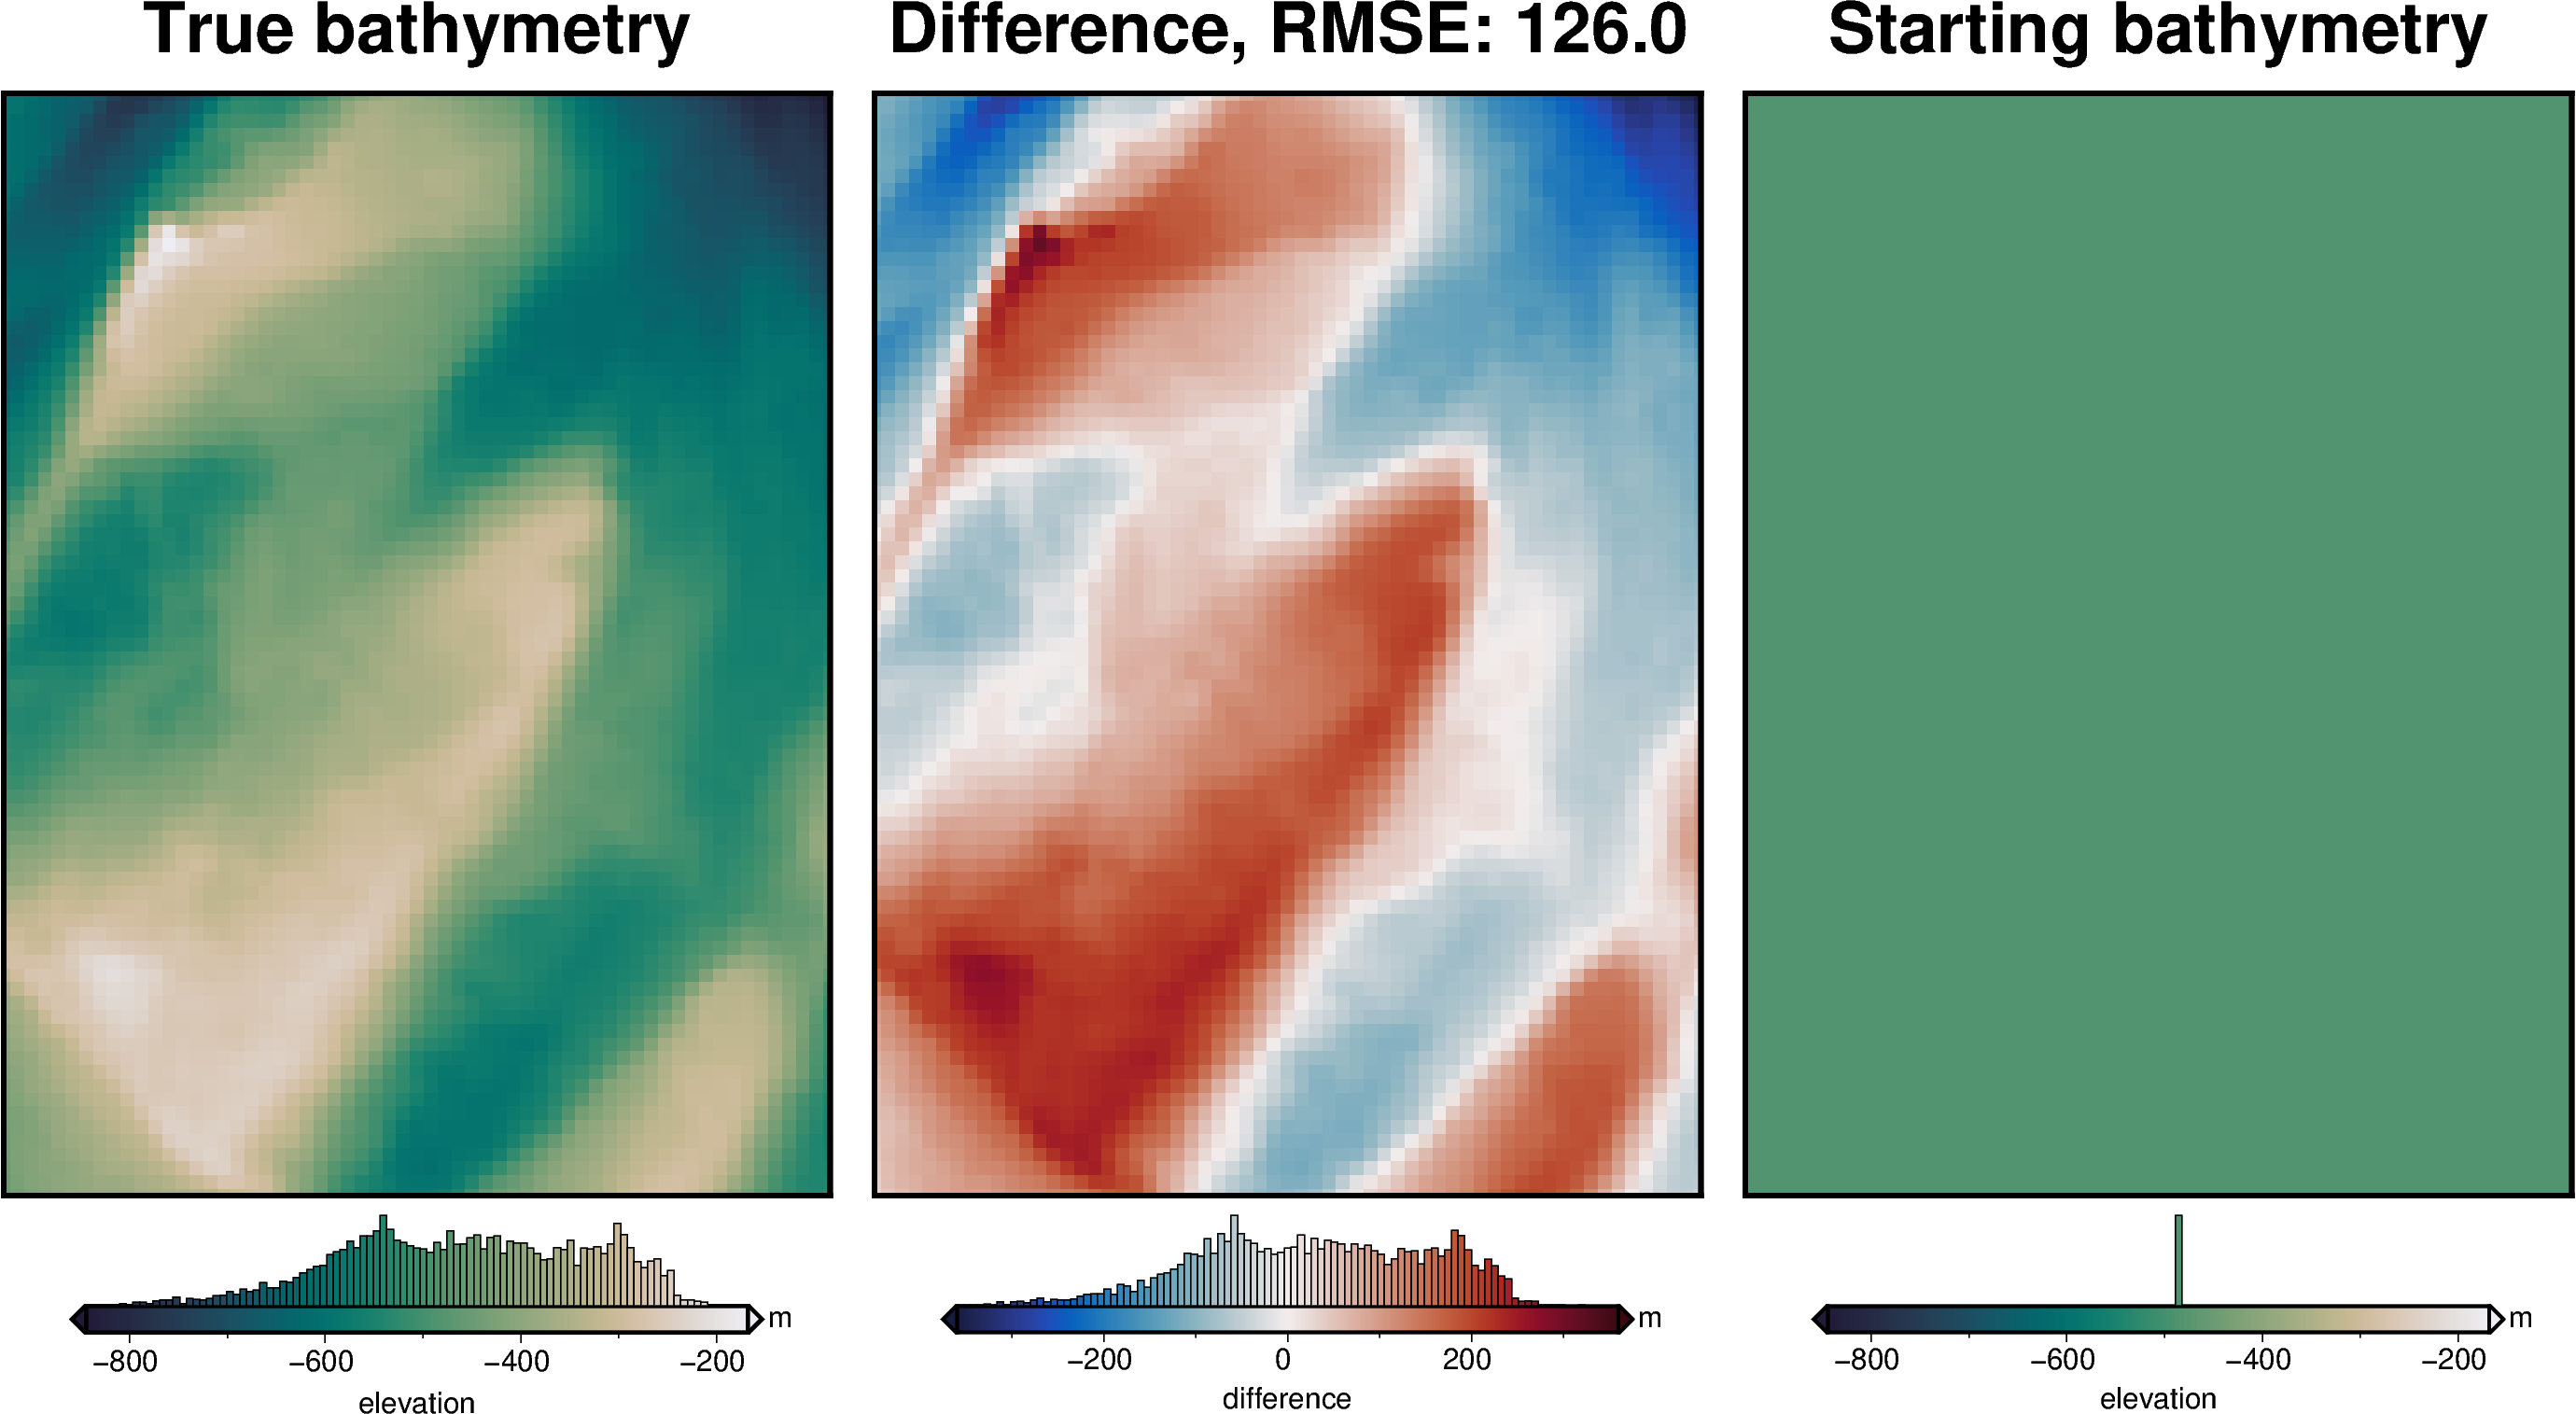

In [6]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    fig_height=10,
    plot=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    diff_cmap="balance+h0",
    grid1_name="True bathymetry",
    grid2_name="Starting bathymetry",
    title="Difference",
    title_font="18p,Helvetica-Bold,black",
    cbar_unit="m",
    cbar_label="elevation",
    RMSE_decimals=0,
    region=inversion_region,
    inset=False,
    hist=True,
    cbar_yoffset=1,
    label_font="16p,Helvetica,black",
)

In [7]:
# the true density contrast is 1476 kg/m3
density_contrast = 1476

# set the reference level from the prisms to 0
zref = 0

density_grid = xr.where(
    starting_bathymetry >=  zref,
    density_contrast,
    -density_contrast,
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)

grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,bathymetry_grav,basement_grav,disturbance,uncert,gravity_anomaly_full_res,starting_gravity
0,-1800000.0,-40000.0,1000.0,-28.046289,0,-28.046289,0.0,-28.046289,-29.341524
1,-1800000.0,-35000.0,1000.0,-26.714502,0,-26.714502,0.0,-26.714502,-29.382051
2,-1800000.0,-30000.0,1000.0,-25.919276,0,-25.919276,0.0,-25.919276,-29.412038
3,-1800000.0,-25000.0,1000.0,-25.236960,0,-25.236960,0.0,-25.236960,-29.434973
4,-1800000.0,-20000.0,1000.0,-24.610928,0,-24.610928,0.0,-24.610928,-29.452985
...,...,...,...,...,...,...,...,...,...
4936,-1400000.0,240000.0,1000.0,-48.323584,0,-48.323584,0.0,-48.323584,-29.452985
4937,-1400000.0,245000.0,1000.0,-48.356131,0,-48.356131,0.0,-48.356131,-29.434973
4938,-1400000.0,250000.0,1000.0,-49.079005,0,-49.079005,0.0,-49.079005,-29.412038
4939,-1400000.0,255000.0,1000.0,-49.877171,0,-49.877171,0.0,-49.877171,-29.382051


# Run ensemble of inversions with varying survey line spacing

In [111]:
# Define spacing between flight lines
# at large spacing, leads to step-increases in resolution
# line_spacings = np.linspace(5e3,180e3,11)

# Define number of flight lines
# linear increase in number of lines results in exponential increase in resolution
# line_spacings = np.linspace(1,50,11).astype(int)

# Define number of flights lines on log scale
line_numbers = np.unique(np.round(np.geomspace(1,40,10)))
# line_numbers = np.linspace(1, 40, 10).astype(int)

line_numbers = [int(i) for i in line_numbers]
line_numbers.reverse()
# line_numbers = [line_numbers[0], line_numbers[4]]
line_numbers

[40, 27, 18, 12, 8, 5, 3, 2, 1]

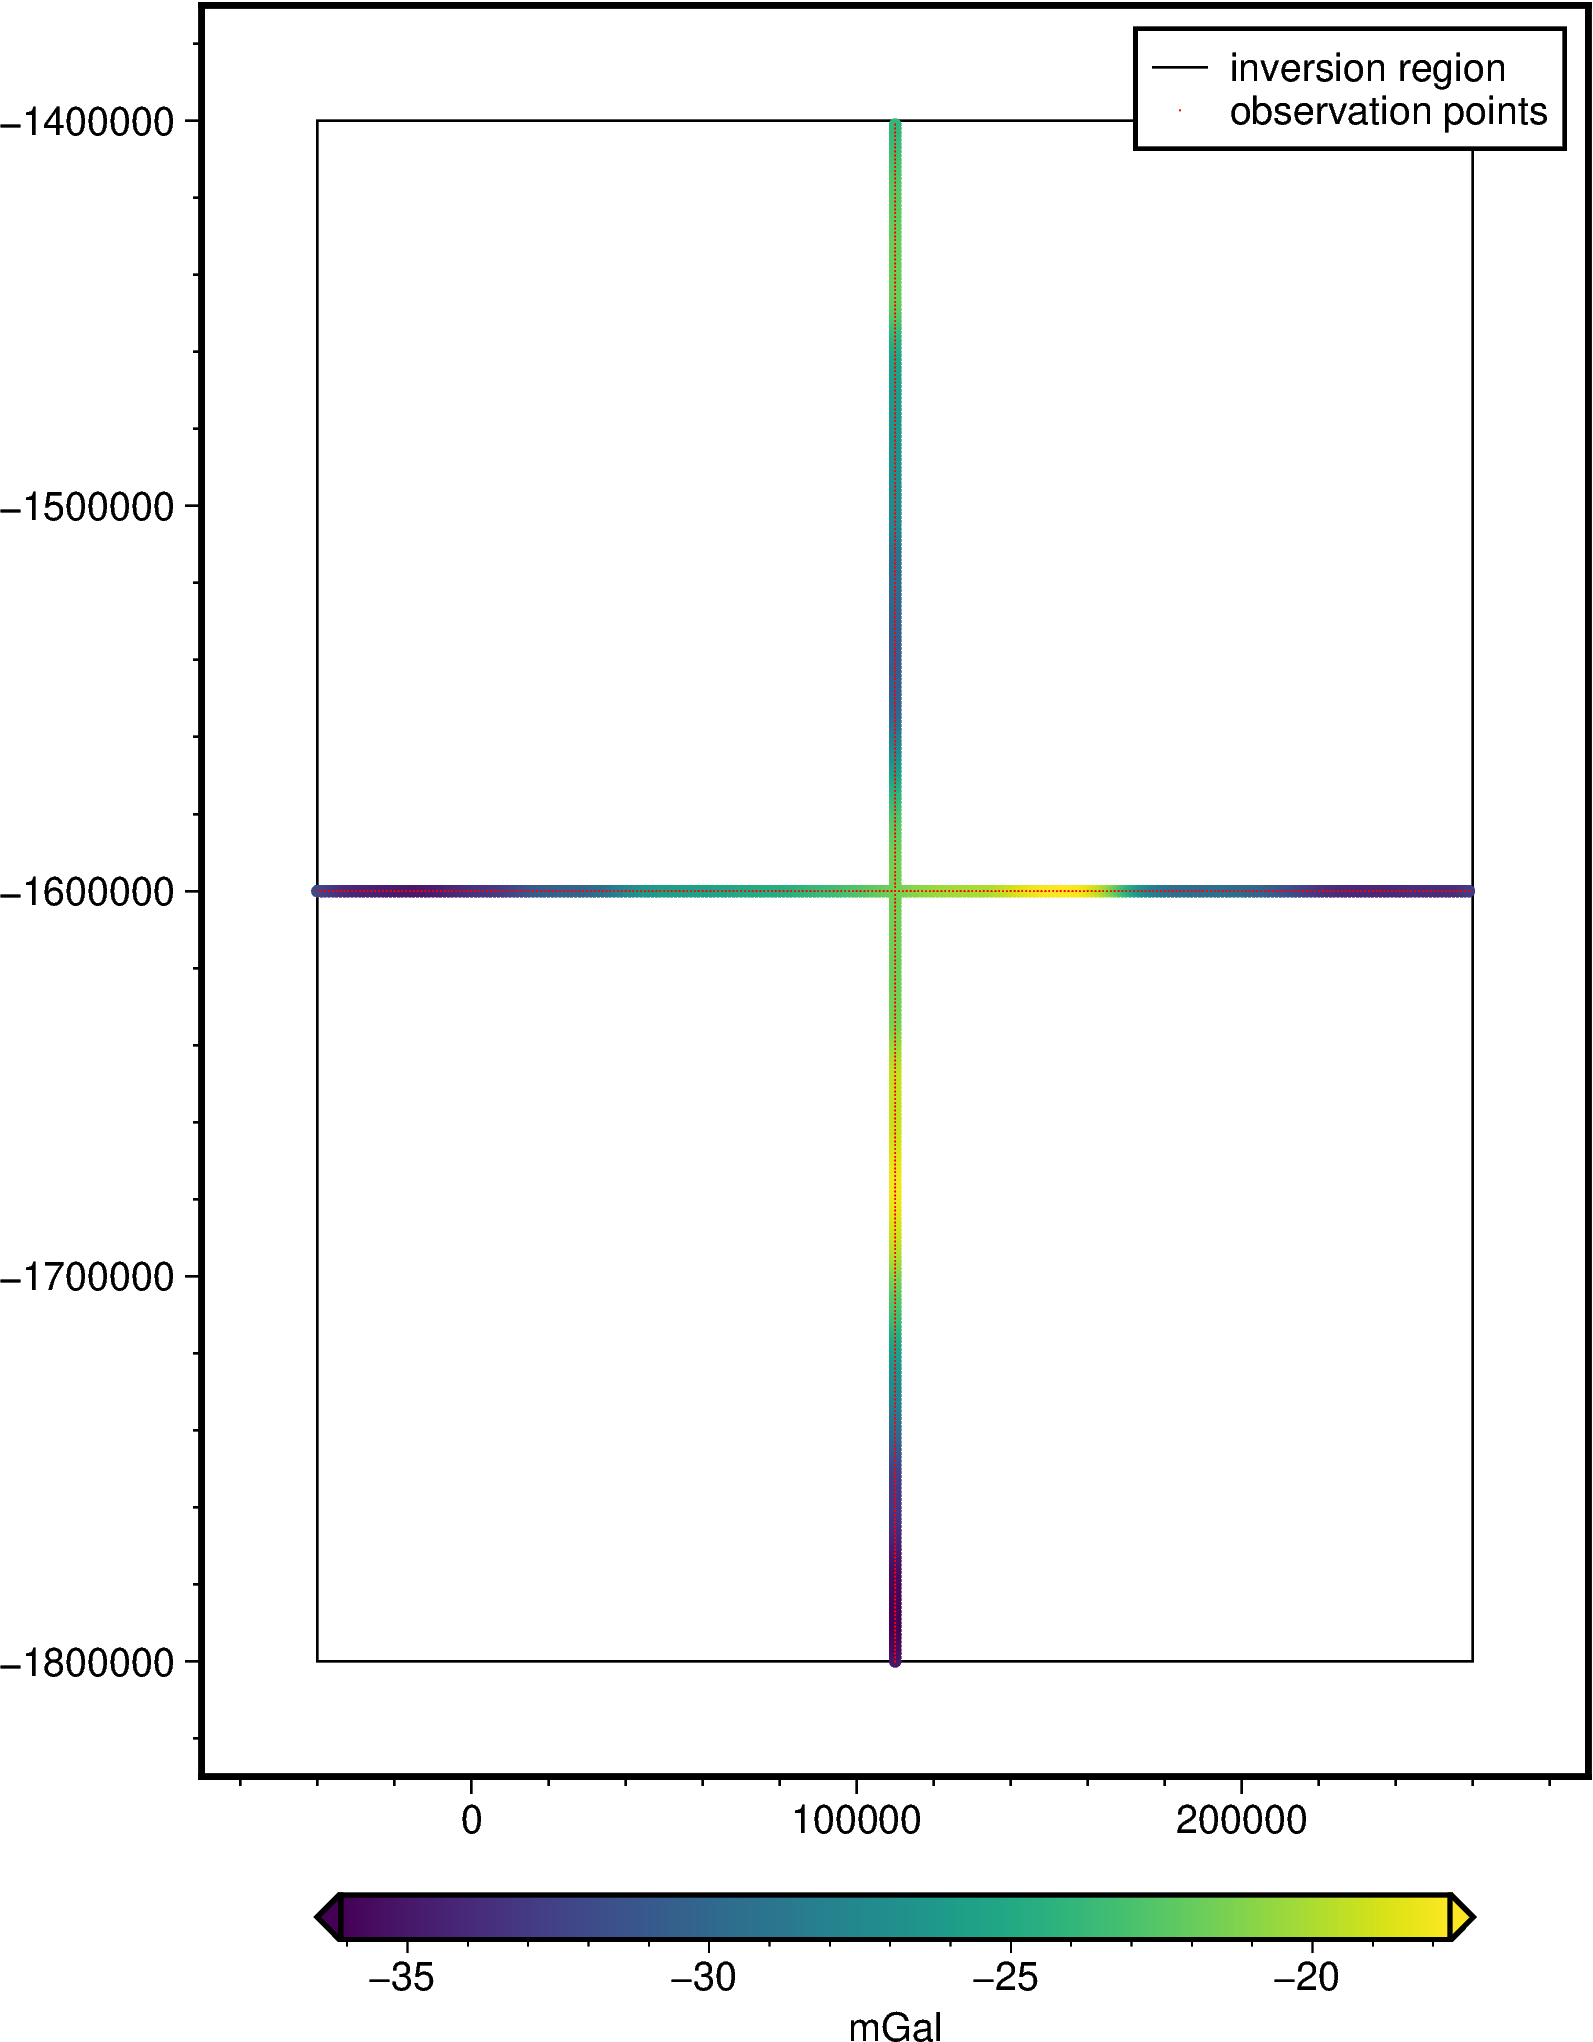

,northing,easting,upward,gravity_anomaly
0,-1800000.0,110000.0,1000.0,-34.941624
1,-1799000.0,110000.0,1000.0,-35.093809
2,-1798000.0,110000.0,1000.0,-35.260707
3,-1797000.0,110000.0,1000.0,-35.429130
4,-1796000.0,110000.0,1000.0,-35.585889
...,...,...,...,...
295,-1600000.0,255000.0,1000.0,-33.756527
296,-1600000.0,256000.0,1000.0,-33.641186
297,-1600000.0,257000.0,1000.0,-33.475804
298,-1600000.0,258000.0,1000.0,-33.285162


In [67]:
grav_survey_df = RIS_synth.airborne_survey(
    along_line_spacing=1e3,
    grav_observation_height=1e3,
    # NS_line_spacing=line_spacings[-1],
    # EW_line_spacing=line_spacings[-1],
    NS_line_number=line_numbers[-1],
    EW_line_number=line_numbers[-1],
    # padding=-spacing*2,
    region=inversion_region,
    grav_grid=grav_df.set_index(['northing', 'easting']).gravity_anomaly_full_res.to_xarray(),
    plot=True,
)
grav_survey_df

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 8
INFO:invert4geom:	parameter: {'depth': 55221.9941565635, 'damping': 9.523568111769604e-08}
INFO:invert4geom:	scores: [0.9889518065853056]


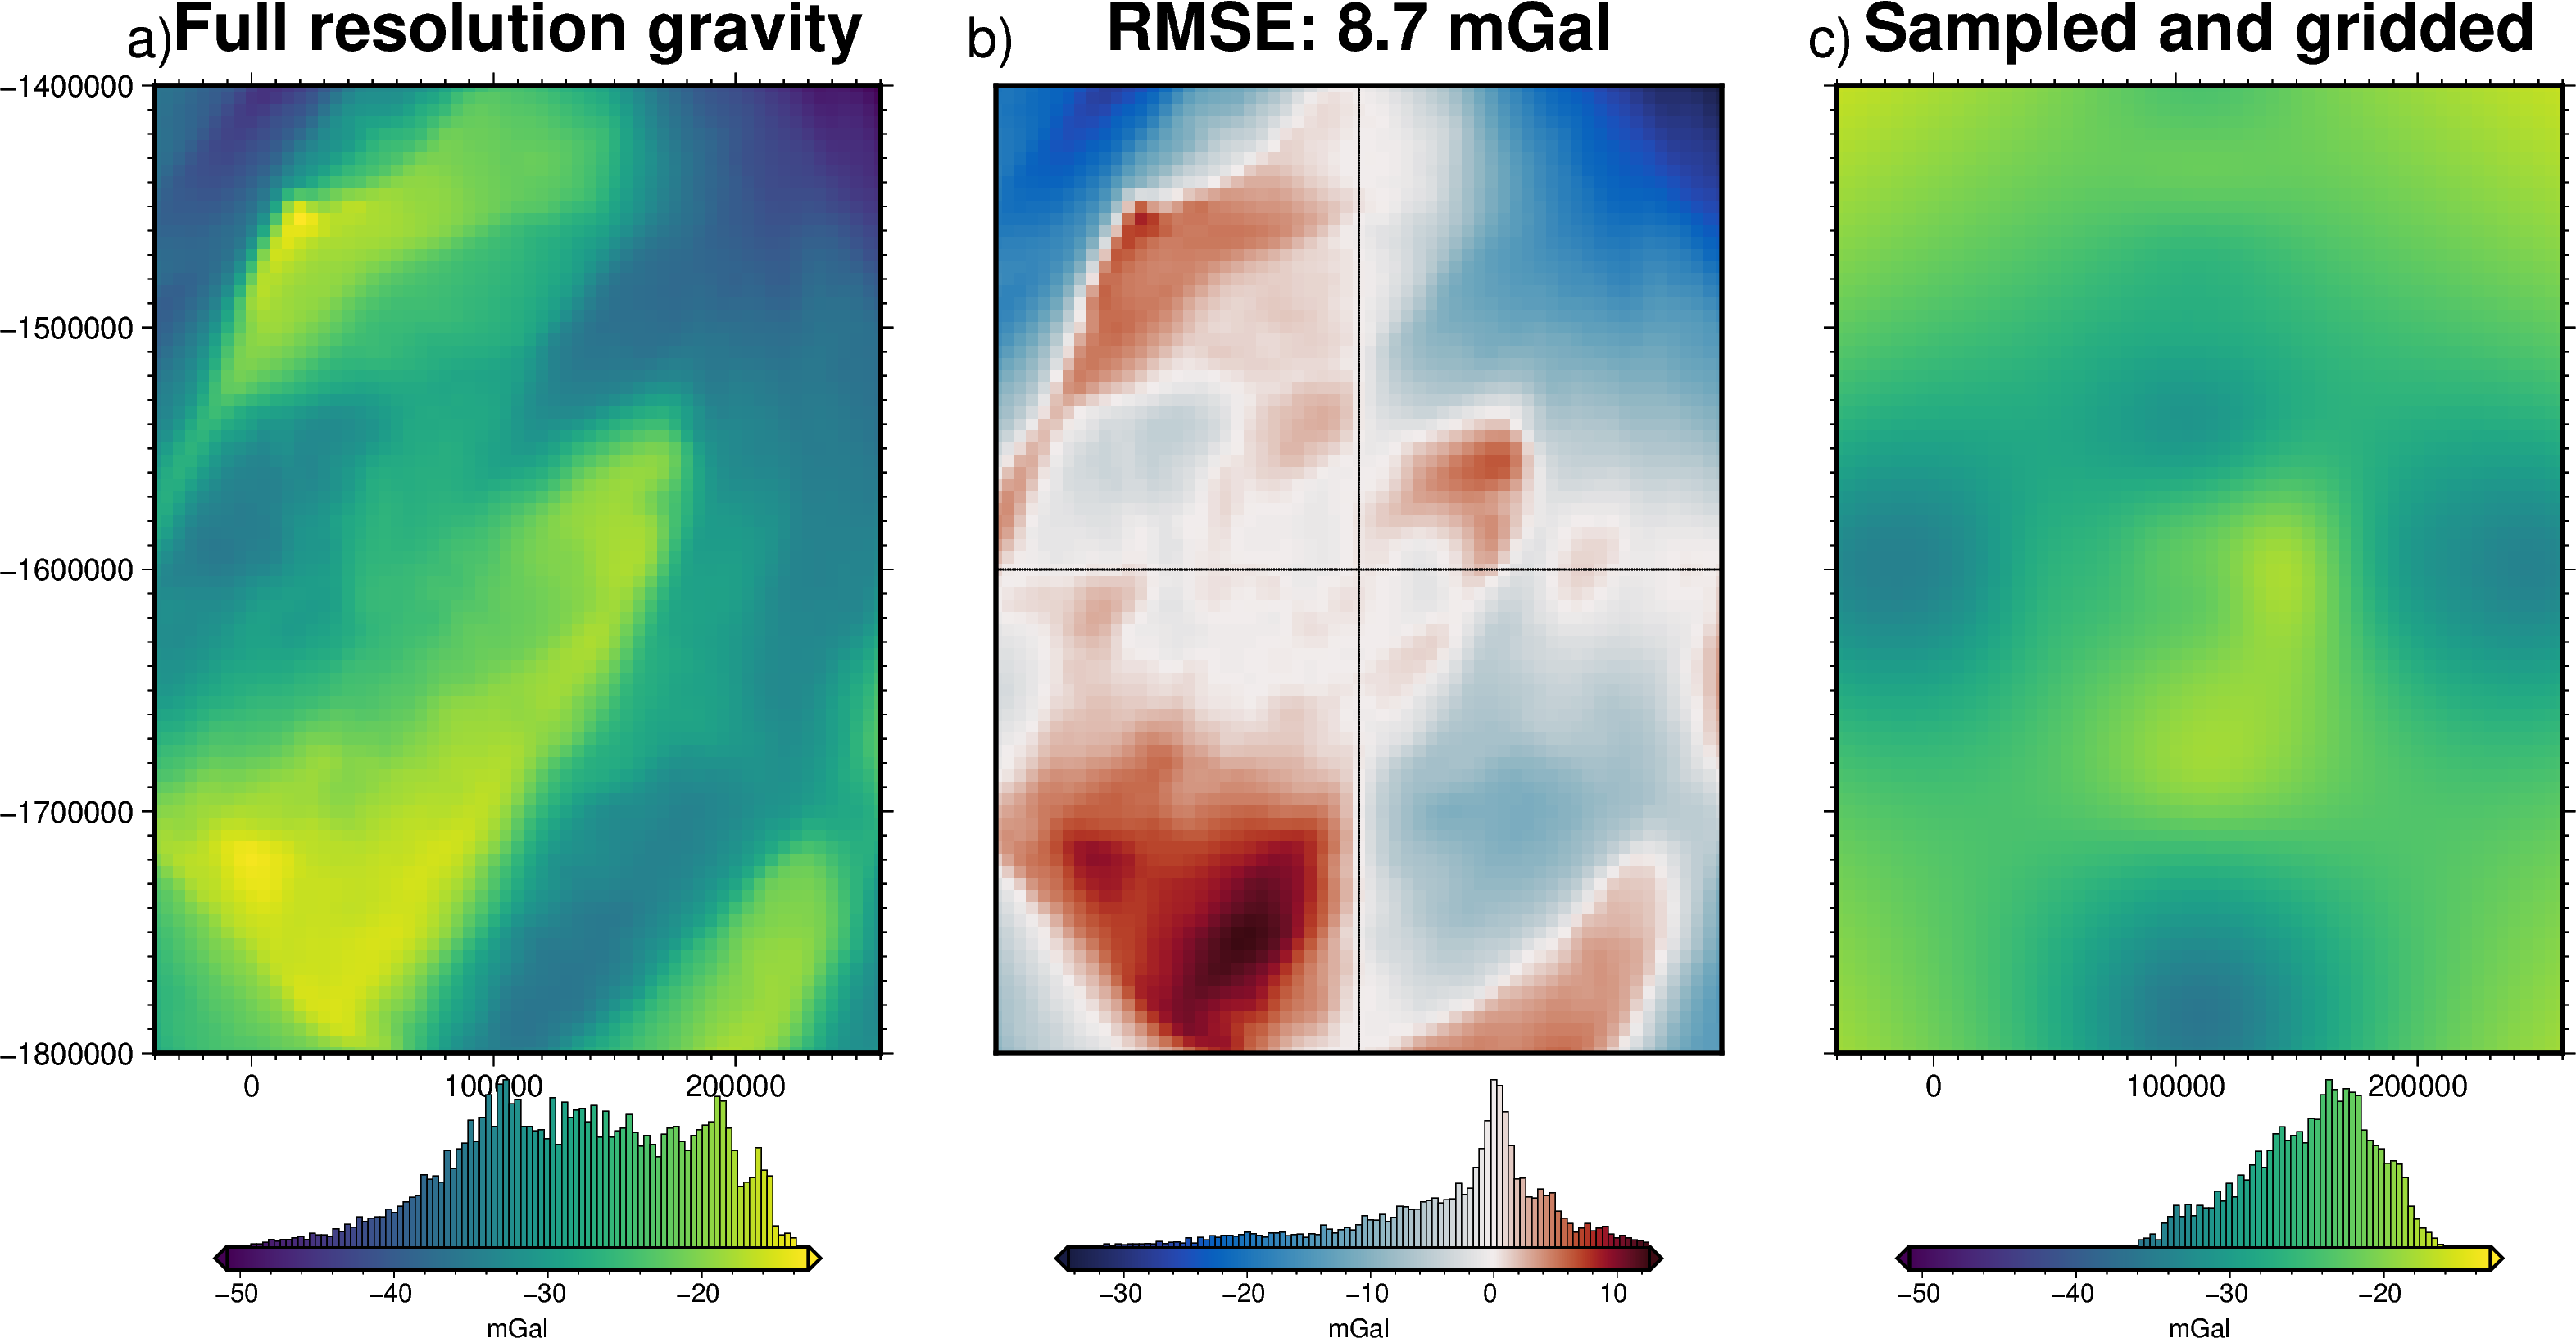

In [24]:
# grid the airborne survey data over the whole grid
coords = (grav_survey_df.easting, grav_survey_df.northing, grav_survey_df.upward)
data = grav_survey_df.gravity_anomaly

study_df, eqs = optimization.optimize_eq_source_params(
    coords,
    data,
    n_trials=10,
    damping_limits=[1e-20, 1],
    depth_limits=[10e3, 200e3],
    block_size=spacing*5,
    # plot=True,
)

# predict sources onto grid
grav_df["gravity_anomaly"] = eqs.predict(
    (
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,  # either grav_df.upward or user-set constant value
    ),
)

grav_grid = grav_df.set_index(['northing', 'easting']).to_xarray()

# plot the synthetic gravity anomaly grid
lims = polar_utils.get_min_max(grav_grid.gravity_anomaly_full_res)

fig = maps.plot_grd(
    grav_grid.gravity_anomaly_full_res,
    fig_height=10,
    cmap="viridis",
    cpt_lims=lims,
    title="Full resolution gravity",
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
    hist=True,
    cbar_yoffset=2,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="16p,Helvetica,black",
    offset="j-.3/.3",
    no_clip=True,
)

dif = (
    grav_grid.gravity_anomaly_full_res - grav_grid.gravity_anomaly
)
fig = maps.plot_grd(
    dif,
    fig_height=10,
    cmap="balance+h0",
    title=f"RMSE: {round(utils.rmse(dif),2)} mGal",
    cbar_label="mGal",
    hist=True,
    cbar_yoffset=2,
    grd2_cpt=True,
    fig=fig,
    origin_shift="xshift",
    xshift_amount=1.1,
)

# plot observation points
fig.plot(
    grav_survey_df[["easting", "northing"]],
    style="c.02c",
    fill="black",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="16p,Helvetica,black",
    offset="j-.3/.3",
    no_clip=True,
)

# plot the synthetic observed gravity grid
fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    fig_height=10,
    cmap="viridis",
    cpt_lims=lims,
    title="Sampled and gridded",
    cbar_label="mGal",
    frame=["nSwe", "xaf10000", "yaf10000"],
    hist=True,
    cbar_yoffset=2,
    fig=fig,
    origin_shift="xshift",
    xshift_amount=1.1,
)
fig.text(
    position="TL",
    justify="BL",
    text="c)",
    font="16p,Helvetica,black",
    offset="j-.3/.3",
    no_clip=True,
)
fig.show()

In [112]:
grav_survey_dfs = []
grav_dfs = []
grav_grids = []
line_spacings = []
for i, s in enumerate(tqdm(line_numbers)):
    grav_survey_df = RIS_synth.airborne_survey(
        along_line_spacing=1e3,
        grav_observation_height=1e3,
        NS_line_number=s,
        EW_line_number=s,
        region=inversion_region,
        grav_grid=grav_df.set_index(['northing', 'easting']).gravity_anomaly_full_res.to_xarray(),
        plot=False,
    )

    grav_survey_dfs.append(grav_survey_df)

    x_spacing=(inversion_region[1]-inversion_region[0])/s
    y_spacing=(inversion_region[3]-inversion_region[2])/s

    line_spacing = round((x_spacing + y_spacing)/2, -3)
    line_spacings.append(line_spacing)

    # grid the airborne survey data over the whole grid
    coords = (grav_survey_df.easting, grav_survey_df.northing, grav_survey_df.upward)
    data = grav_survey_df.gravity_anomaly

    study, eqs = optimization.optimize_eq_source_params(
        coords,
        data,
        n_trials=10,
        damping_limits=[1e-20, 1],
        depth_limits=[10e3, 200e3],
        block_size=spacing*5,
        # plot=True,
    )

    # copy gravity dataframe
    df = copy.deepcopy(grav_df)

    # predict sources onto grid
    df["gravity_anomaly"] = eqs.predict(
        (
            df.easting,
            df.northing,
            df.upward,  # either grav_df.upward or user-set constant value
        ),
    )

    df = regional.regional_separation(
        grav_df=df,
        method="constant",
        constant=0,
    )
    grav_dfs.append(df)

    grav_grid = df.set_index(["northing", "easting"]).to_xarray()
    grav_grids.append(grav_grid)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'depth': 76670.97437942804, 'damping': 1.8220093796792354e-12}
INFO:invert4geom:	scores: [0.991469454373798]


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'depth': 76670.97437942804, 'damping': 1.8220093796792354e-12}
INFO:invert4geom:	scores: [0.9913800084344642]


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'depth': 76670.97437942804, 'damping': 1.8220093796792354e-12}
INFO:invert4geom:	scores: [0.9913781077745074]


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 9
INFO:invert4geom:	parameter: {'depth': 55357.550999746956, 'damping': 1.3735781186963916e-15}
INFO:invert4geom:	scores: [0.9931882010438455]


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'depth': 76670.97437942804, 'damping': 1.8220093796792354e-12}
INFO:invert4geom:	scores: [0.9933594447977164]


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 7
INFO:invert4geom:	parameter: {'depth': 59040.117553642966, 'damping': 3.6133578197394906e-12}
INFO:invert4geom:	scores: [0.9958401517067527]


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'depth': 76670.97437942804, 'damping': 1.8220093796792354e-12}
INFO:invert4geom:	scores: [0.9916436865136438]


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 5
INFO:invert4geom:	parameter: {'depth': 102729.52917645473, 'damping': 7.592913733340257e-13}
INFO:invert4geom:	scores: [0.9956277689661459]


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 8
INFO:invert4geom:	parameter: {'depth': 55221.9941565635, 'damping': 9.523568111769604e-08}
INFO:invert4geom:	scores: [0.9889518065853056]


<Axes: >

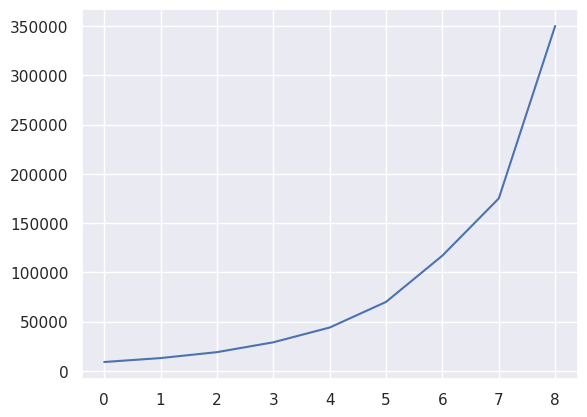

In [120]:
pd.Series(line_spacings).plot()

<Axes: >

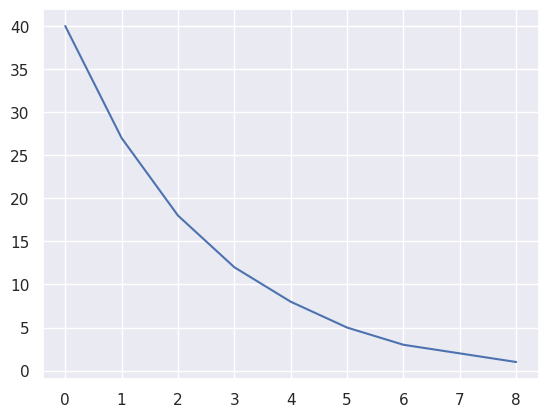

In [121]:
pd.Series(line_numbers).plot()

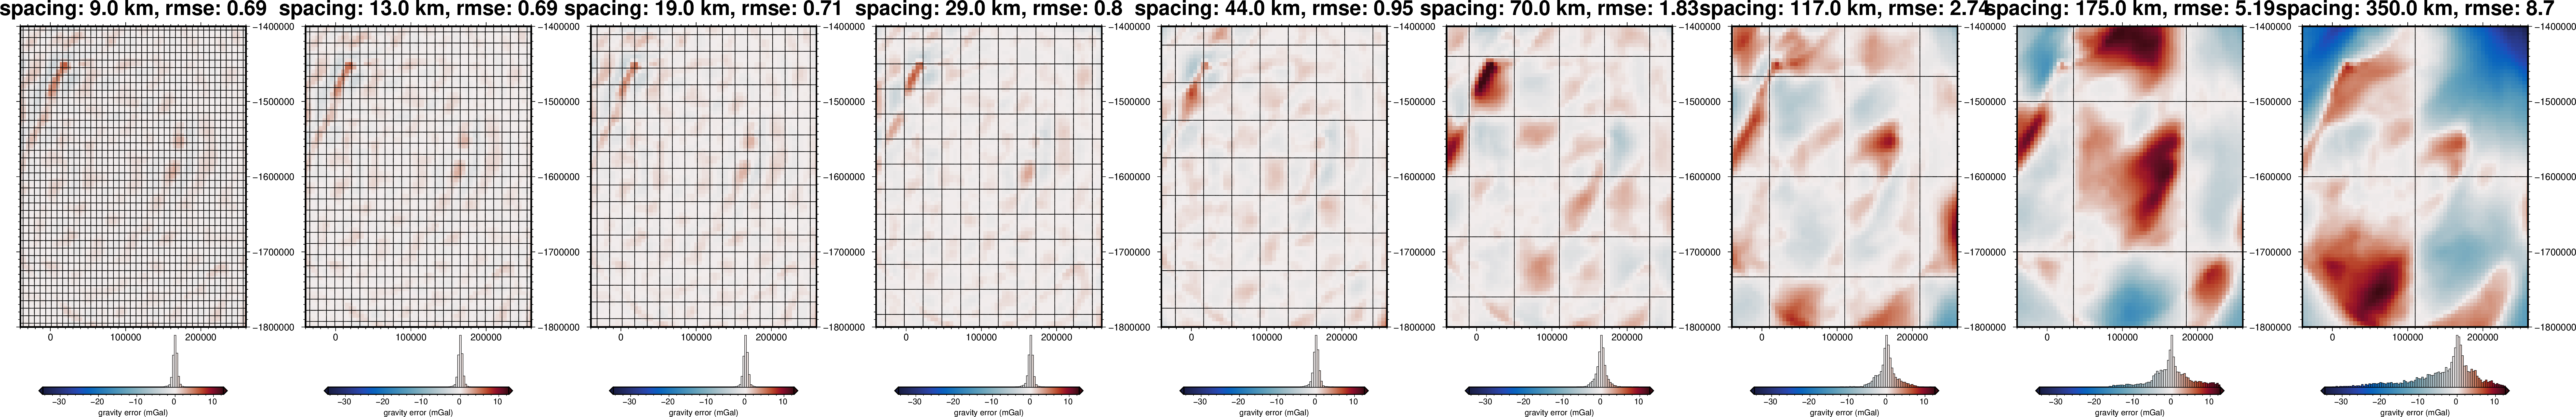

In [113]:
cpt_lims = polar_utils.get_min_max(grav_grid.gravity_anomaly_full_res - grav_grids[-1].gravity_anomaly)
# cpt_lims = polar_utils.get_combined_min_max(g.res for g in grav_grids)

rmses = []
for i, g in enumerate(grav_grids):
    if i == 0:
        fig = None
        origin_shift="initialize"

    else:
        origin_shift="xshift"

    dif = (g.gravity_anomaly_full_res - g.gravity_anomaly)
    fig = maps.plot_grd(
        # g.res,
        dif,
        region=inversion_region,
        fig_height=10,
        fig=fig,
        origin_shift=origin_shift,
        title=f"spacing: {line_spacings[i]/1e3} km, rmse: {round(utils.rmse(dif),2)}",
        cmap="balance+h0",
        cpt_lims=cpt_lims,
        hist=True,
        cbar_label="gravity error (mGal)",
        frame=["nSwE", "xaf10000", "yaf10000"],
        points=grav_survey_dfs[i][["easting", "northing"]],
        points_style="p.02c",
        xshift_amount=1.2,
    )
    rmses.append(utils.rmse(dif))

fig.show()

<Axes: >

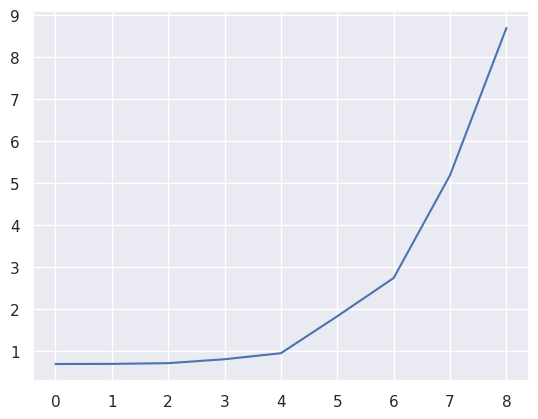

In [114]:
pd.Series(rmses).plot()

In [60]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": .01**.5, # square root of the gravity noise
    "delta_l2_norm_tolerance": 1.008,
}


In [ ]:
logging.getLogger().setLevel(logging.INFO)

for i, df in enumerate(tqdm(grav_dfs)):
    # run the inversion workflow, including a cross validation for the damping parameter
    results = inversion.run_inversion_workflow(
        grav_df=df,
        starting_prisms=starting_prisms,
        # for creating test/train splits
        grav_spacing=spacing,
        inversion_region=inversion_region,
        # solver_damping=0.025,
        run_damping_cv=True,
        damping_limits=(0.001, 0.1),
        damping_cv_trials=5,
        plot_cv=True,
        fname=f"../../results/Ross_Sea_06_damping_cv_line_spacing_{line_numbers[i]}",
        **kwargs,
    )
    # plotting.plot_inversion_results(
    #     results[1],
    #     results[0],
    #     results[2],
    #     inversion_region,
    #     iters_to_plot=4,
    #     plot_iter_results=True,
    #     plot_topo_results=False,
    #     plot_grav_results=True,
    # )


In [117]:
scores = []
rmses = []
dampings = []

for i, n in enumerate(line_numbers):
    fname=f"../../results/Ross_Sea_06_damping_cv_line_spacing_{n}"

    with pathlib.Path(f"{fname}_results.pickle").open("rb") as f:
        results = pickle.load(f)

    with pathlib.Path(f"{fname}_damping_cv_study.pickle").open("rb") as f:
        study = pickle.load(f)
    dampings.append(study.best_params["damping"])
    scores.append(study.best_value)

    final_topo = results[0].set_index(["northing", "easting"]).to_xarray().topo
    inside_final_topo = final_topo.sel(
        northing=slice(inversion_region[2], inversion_region[3]),
        easting=slice(inversion_region[0], inversion_region[1]),
    )
    inside_bathy = bathymetry.sel(
        northing=slice(inversion_region[2], inversion_region[3]),
        easting=slice(inversion_region[0], inversion_region[1]),
    )
    rmse = utils.rmse(inside_final_topo-inside_bathy)
    rmses.append(rmse)

    # if i % 1 == 0:
    #     plotting.plot_inversion_results(
    #         results[1],
    #         results[0],
    #         results[2],
    #         inversion_region,
    #         iters_to_plot=4,
    #         plot_iter_results=True,
    #         plot_topo_results=False,
    #         plot_grav_results=True,
    #     )
    #     _ = polar_utils.grd_compare(
    #         inside_bathy,
    #         inside_final_topo,
    #         plot=True,
    #         grid1_name="True topography",
    #         grid2_name="Inverted topography",
    #         robust=True,
    #         hist=True,
    #         inset=False,
    #         verbose="q",
    #         title="difference",
    #         grounding_line=False,
    #         reverse_cpt=True,
    #         cmap="rain",
    #     )

ensemble_df = pd.DataFrame(
    {
        "line_spacing_km": [l/1e3 for l in line_spacings],
        "line_numbers": line_numbers,
        "score": scores,
        "rmse": rmses,
        "dampings": dampings,
    }
)
ensemble_df

,line_spacing_km,line_numbers,score,rmse,dampings
0,9.0,40,0.044183,15.871039,0.024578
1,13.0,27,0.044040,15.874734,0.024578
2,19.0,18,0.043247,15.881453,0.049581
3,29.0,12,0.041169,16.758175,0.049580
4,44.0,8,0.044518,19.946787,0.024578
5,70.0,5,0.041727,34.201479,0.039549
6,117.0,3,0.037581,49.262121,0.049576
7,175.0,2,0.036817,89.857932,0.049553
8,350.0,1,0.037148,147.944088,0.049516


In [118]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    region=inversion_region,
)
starting_rmse = utils.rmse(grids[0])

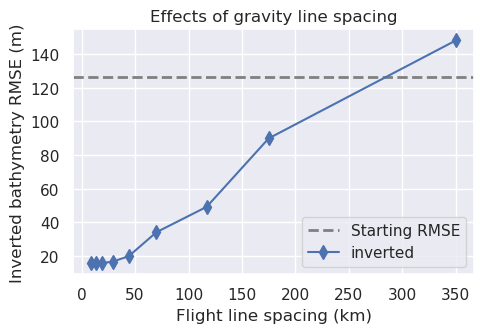

In [119]:
RIS_plotting.plot_1var_ensemble(
    df=ensemble_df,
    x="line_spacing_km",
    y="rmse",
    title="Effects of gravity line spacing",
    xlabel="Flight line spacing (km)",
    ylabel="Inverted bathymetry RMSE (m)",
    horizontal_line=starting_rmse,
    horizontal_line_label="Starting RMSE",
    # logx=True,
)